# Check Duplicates
After balancing the models in 02_balancing_metabolic_models, we're now using Macaw (and Memote) to check more in-depth the topology of our models. The focus is on getting rid of duplicates.
The Macaw parts, i.e. doing Macaw and automated Macaw fixes were written by Frowin. The seconf part of the Notebook starting at Manual Metabolite Duplicate Removal is then my own.

# Imports

In [1]:
from cobra.io import read_sbml_model, write_sbml_model, save_json_model
import os
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt
from cobra.manipulation.validate import check_mass_balance
from itertools import cycle
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import ast
from requests.sessions import merge_hooks
from macaw.main import *
import os

# Macaw
Similar to Memote, macaw is also a software for testing metabolic models regarding duplicates, dead-ends,.. \
see: Moyer, D. C., Reimertz, J., Segrè, D., & Fuxman Bass, J. I. (2025). MACAW: a method for semi-automatic detection of errors in genome-scale metabolic models. Genome Biology 2025 26(1). https://doi.org/10.1186/S13059-025-03533-6

## Redox_pairs, proton_ids, phosphate_ids

In [81]:
redox_pairs = [
    # NAD(H), NADP(H), FAD(H2), and FMN(H2)
    ('nad_c', 'nadh_c'), ('nadp_c', 'nadph_c'), ('fad_c', 'fadh2_c'),
    ('fmn_c', 'fmnh2_c'),
    # ubiquinone-8 and ubiquinol-8
    ('q8_c', 'q8h2_c'),
    # menaquinone-8 and menaquinol-8
    ('mqn8_c', 'mql8_c'),
    # riboflavin
    ('ribflv_c', 'rbflvrd_c'),
    # glutathione
    ('gthox_c', 'gthrd_c'),
    # glutaredoxin
    ('grxox_c', 'grxrd_c'),
    # thioredoxin
    ('trdox_c', 'trdrd_c'),
    # flavodoxin (reduced and semi-oxidized)
    ('flxso_c', 'flxr_c'),
    # oxygen and hydrogen peroxide
    ('o2_c', 'h2o2_c')
]

# protons in all compartments
proton_ids = ['h_c', 'h_e', 'h_p']

# Phosphate in all compartments
pi_ids = ["pi_c", "pi_p", "pi_e"]
ppi_ids = ["ppi_c", "ppi_p", "ppi_e"]

In [82]:
def filter_existing_redox_pairs(model, redox_pairs):
    metabolites = {met.id for met in model.metabolites}
    return [pair for pair in redox_pairs if pair[0] in metabolites and pair[1] in metabolites]

## Main
we're doing all macaw Tests beside the dilution test because this test has a very high runtime!

In [83]:
# Directory where models are
model_dir = "/home/lisa/Dokumente/Programmierung/Models/08_charge_balanced/"

# Directory in which you want to save the resulting csv files
save_dir = '/home/lisa/Dokumente/Programmierung/Reports/A_Macaw_after_first_charge_balance'

In [74]:
def do_macaw(model_dir, save_dir):
    for file in (f for f in os.listdir(model_dir) if f.endswith(".xml")):

        model = read_sbml_model(os.path.join(model_dir, file))
        model.solver = "cplex"

        (diphosphate_results) = diphosphate_test(model, ppi_ids, pi_ids)

        # not every redox pair is in every model, so we filter first which redox pairs we actually have
        filtered_pairs = filter_existing_redox_pairs(model, redox_pairs)
        (duplicate_results, duplicate_edge_list) = duplicate_test(model, filtered_pairs, proton_ids)

        (dead_end_results, dead_end_edge_list) = dead_end_test(model)

        macaw_results = duplicate_results.merge(diphosphate_results)
        macaw_results = macaw_results.merge(dead_end_results)

        # save results to csv
        file = f"{file[:3]}_macaw_results.csv"
        macaw_results.to_csv(os.path.join(save_dir, file), index=False)

        print(f"Finished processing {file}")
        print("---------------")

In [75]:
do_macaw(model_dir, save_dir)

Starting diphosphate test...
 - Found 3 suspiciously reversible reactions that involve diphosphate.
Starting duplicate test...
 - Found 250 reactions that were some type of duplicate:
   - 6 were completely identical to at least one other reaction.
   - 50 involve the same metabolites but go in the opposite direction or have the opposite reversibility as at least one other reaction.
   - 108 involve the same metabolites but with different coefficients as at least one other reaction.
   - 134 redox reactions oxidize and/or redox the same metabolites as another redox reaction but use a different pair of the given redox carriers.
Starting dead-end test...
 - Found 40 dead-end metabolites.
 - Found 38 reactions incapable of sustaining steady-state fluxes in either direction due to these dead-ends.
 - Found 354 reversible reactions that can only carry steady-state fluxes in a single direction due to dead-ends.
Finished processing AA4_macaw_results.csv
Starting diphosphate test...
 - Found 7

# Automated Duplicate Fixes according to Macaw
Based on our results that we got from macaw, we can use them to eliminate some duplicates that are very obvious. We're basing this especially on the GPRs (gene-protein-rule), i.e. if two reaction are flagged as duplicates and have same gpr (reactions or rather enzymes come from same gene) then we can be sure that these are actually duplicates

In [76]:
# Path to your models
model_dir = '/home/lisa/Dokumente/Programmierung/Models/08_charge_balanced/'

# Path to the .csv files created by the "MACAW_Phase_1_tests" script
test_results_dir = '/home/lisa/Dokumente/Programmierung/Reports/A_Macaw_after_first_charge_balance/'

# Path where the new, fixed models (xml files) should be stored
fixed_model_dir = '/home/lisa/Dokumente/Programmierung/Models/09_macaw_fixes/'

## Functions

In [77]:
# Summarizes the test results for the diphophate test throughout all files in the test_results_dir
def create_diphsophate_overview(test_results_dir):

    # Create lists to store the reactions that should be irreversible and those that should be flipped and made irreversible
    irreversible = list()
    flipped_and_irr = list()

    # Iterate through the test results directory and read each CSV file
    for file in os.listdir(test_results_dir):
        if file.endswith(".csv"):
            df = pd.read_csv(test_results_dir+file)

            # Create smaller df that only contain the rows with the columns of interest
            # and put all ids in the corresponding list
            irreversible_df = df[df.iloc[:, 6] == 'should be irreversible']
            irreversible.extend(irreversible_df.iloc[:, 0].tolist())
            flipped_and_irr_df = df[df.iloc[:, 6] == 'should be flipped and made irreversible']
            flipped_and_irr.extend(flipped_and_irr_df.iloc[:, 0].tolist())

    # Remove duplicates from the lists
    irreversible = list(set(irreversible))
    flipped_and_irr = list(set(flipped_and_irr))

    # Print the results
    print(f"{len(irreversible)} reactions should be Irreversible reactions:")
    for i in irreversible:
        print(i)
    print("-------------------------------------------------------------------------\n")
    print(f"{len(flipped_and_irr)} reactions should be Flipped and irreversible reactions:")
    for i in flipped_and_irr:
        print(i)

In [78]:
# A function to create singular reaction pairs in all duplicate lists
# This is necessary since some reactions have several duplicate reactions

# The function takes a list of tuples as input
def formate_duplicate_pairs(duplicate_list):

    # Create a new duplicate list for the formated results at the end = output list
    formated_duplicate_list = list()

    # Iterate through all pairs in the input list and check if there are multiple duplicates for the same reaction
    # This is indicated by the presence of a semicolon
    for r1, r2 in duplicate_list:

        # If a semicolon is found new pairs will be created and added to the output list
        if ";" in r2:

            # Split the string by semicolon and create new pairs
            r2_list = r2.split(";")

            # Create a list for new pairs
            new_pairs = list()

            # Create new pairs from all duplicates and add them to the new_pairs list
            # The new pairs will be sorted to later remove doubles
            for r in r2_list:
                new_pairs.append(tuple(sorted((r1, r))))

            # Extend the output list with new pairs
            formated_duplicate_list.extend(new_pairs)

        # When no semicolon is found the pair is sorted and just added to the output list
        else:
            formated_duplicate_list.append(tuple(sorted((r1, r2))))

    # Remove all duplucate pairs (so all pairs of duplicates that are in the list multiple times)
    formated_duplicate_list = list(set(formated_duplicate_list))

    # Return the formated list of duplicates
    # This is also a list of tuples and most likely longer than the input
    return formated_duplicate_list

In [93]:
# Use the .csv files from the first MACAW tests to create a list of all 'duplicate pairs' for a model;
# This will be four lists of tuples that represent all reactions in the model that where flagged by;
# MACAW has an exact-, directional-, coefficient- or redox-duplicate

# This takes the model_id as input (without any format suffix)
def get_all_duplicate_pairs(model_id):

    # The name of the test_result file corresponding to this model is assumed and the csv is read
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!CHANGE THIS DEPENDING ON YOUR NAMING CONVENTION!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    test_results = pd.read_csv(test_results_dir+f"{model_id[:3]}_macaw_results.csv")

    # Filter reactions with entries not equal to "ok" in the specified columns
    duplicates_df = test_results.loc[
        (test_results['duplicate_test_exact'] != 'ok') |
        (test_results['duplicate_test_directions'] != 'ok') |
        (test_results['duplicate_test_coefficients'] != 'ok') |
        (test_results['duplicate_test_redox'] != 'ok'),
        ['reaction_id', 'duplicate_test_exact', 'duplicate_test_directions', 'duplicate_test_coefficients', 'duplicate_test_redox']
    ]

    # Create a dict containing the model reactions as keys and the test results for each test as value (dict)
    # This will contain all reactions that were flagged by at least one duplicate test
    model_duplicates_dict = {
        row['reaction_id']: {
            "Exact": row['duplicate_test_exact'],
            "Directions": row['duplicate_test_directions'],
            "Coefficient": row['duplicate_test_coefficients'],
            "Redox": row['duplicate_test_redox']
        }
        for _, row in duplicates_df.iterrows()
    }

    # Create lists for all types of duplicates
    exact_duplicates = list()
    directional_duplicates = list()
    coefficient_duplicates = list()
    redox_duplicates = list()

    # Iterate through all reactions and corresponding duplicate test results
    for reaction_id, tests in model_duplicates_dict.items():

        # Append all reactions flagged by MACAW and the corresponding duplicate reactions
        if tests['Exact'] != 'ok':
            exact_duplicates.append((reaction_id, tests['Exact']))
        if tests['Directions'] != 'ok':
            directional_duplicates.append((reaction_id, tests['Directions']))
        if tests['Coefficient'] != 'ok':
            coefficient_duplicates.append((reaction_id, tests['Coefficient']))
        if tests['Redox'] != 'ok':
            redox_duplicates.append((reaction_id, tests['Redox']))


    # Apply the format_duplicate_pairs function to split reactions with multiple duplicates for the same type
    # into singular pairs (see function below)
    exact_duplicates = formate_duplicate_pairs(exact_duplicates)
    directional_duplicates = formate_duplicate_pairs(directional_duplicates)
    coefficient_duplicates = formate_duplicate_pairs(coefficient_duplicates)
    redox_duplicates = formate_duplicate_pairs(redox_duplicates)

    # Returns all 4 lists
    return exact_duplicates, directional_duplicates, coefficient_duplicates, redox_duplicates

In [80]:
# Creates a dictionary containing all reactions in the model as keys
# The value is always a list of the sorted genes corresponding to this reaction
# OR ["None"] if no GPR could be found for this reaction in this model

# Input is a cobra model object
def create_gpr_list_dir(model):

    # Create the output dict
    gpr_list_dir = {}

    # Iterate through all reactions in the model
    for reaction in model.reactions:

        # Get the GPR as string
        gpr_string = reaction.gene_reaction_rule

        # If no GPR is given set ["None"] as the value in the output dict
        if gpr_string == '':
            gpr_list_dir[reaction.id] = ["None"]

        # If GPR are found formate them into a list by first splitting them by the 'or' relation
        # Genes with an 'and' relation will be split further and added to the GPR list as an list themself
        else:
            gpr_list_or_split = list(gpr_string.split(' or '))

            # Create a list where both 'or' and 'and' relations are kept = Value list
            gpr_list_or_and_split = []

            # Check if an entry in the list contains an 'and'
            for entry in gpr_list_or_split:

                # If yes the split this entry into a new list, clean it and add the list to the value list
                if 'and' in entry:
                    new_entry = list(entry.split(' and '))
                    new_entry_cleaned = [s.replace("(", "").replace(")", "") for s in new_entry]

                    # Sort this sublist alphabetically
                    gpr_list_or_and_split.append(sorted(new_entry_cleaned))

                # If no then just append the entry into the output list
                else:
                    gpr_list_or_and_split.append(entry)

            # Sort the output list alphabetically by treating each entry as a string
            # Add the sorted value list to the output dict
            gpr_list_dir[reaction.id] = sorted(gpr_list_or_and_split, key=lambda x: ' '.join(x) if isinstance(x, list) else x)

    # Output is a dict with an entry for each reaction in the input model
    return gpr_list_dir

In [81]:
# A function to compare GPR lists created by the create_gpr_list_dir function
# The output is highly variable and specific
# Only strings describing the relation of the GPR for both input reactions are returned

# Input are two reaction_ids
def compare_gpr_lists(r1, r2):

    # GPR lists for both input reactions are fetched from the dir
    r1_gpr = gpr_list_dir[r1]
    r2_gpr = gpr_list_dir[r2]

    # If either of the reactions has no GPR it is checked if they are both boundary reactions or not
    if (r1_gpr[0] == "None") or (r2_gpr[0] == "None"):
        if (model.reactions.get_by_id(r1) in model.boundary) and (model.reactions.get_by_id(r2) in model.boundary):
            return 'No GPR and both boundary reactions'
        else:
            return 'No GPR but one not a boundary reaction'

    # Do they have the same GPR list?
    elif r1_gpr == r2_gpr:
        return 'Same GPR list'

    # Is the list the same lenght and shares genes or not?
    elif len(r1_gpr) == len(r2_gpr):
        if any(item in r1_gpr for item in r2_gpr):
            return 'Same length of GPR list and share some genes'
        else:
            return 'Same length of GPR list but no common genes'

    # Are the lists of different lenght and:
    # Is one list a sublist of the other?
    # Share the lists genes or not?
    else:
        if (len(r1_gpr) > len(r2_gpr)) and all(item in r1_gpr for item in r2_gpr):
            return 'r2 in r1'
        elif (len(r2_gpr) > len(r1_gpr)) and all(item in r2_gpr for item in r1_gpr):
            return 'r1 in r2'
        elif any(item in r1_gpr for item in r2_gpr):
            return 'Different lenght of GPR list and share some genes'
        else:
            return 'Different lenght of GPR list but no common genes'


In [82]:
# Exact duplicates will be removed or combined based on their GPR

def fix_exact_duplicates():

    # Compare the GPR lists of both reactions and apply fixes depending on the returned status
    for r1, r2 in exact_duplicates:
        status = compare_gpr_lists(r1, r2)

        # Delete one reaction if they have the same GPR
        if status == "Same GPR list":
            model.remove_reactions([model.reactions.get_by_id(r2)])

        # If the GPR list of r2 is a substring of the r1 GPR list, delete r2
        elif status == "r2 in r1":
            model.remove_reactions([model.reactions.get_by_id(r2)])

        # If the GPR list of r1 is a substring of the r2 GPR list, delete r1
        elif status == "r1 in r2":
            model.remove_reactions([model.reactions.get_by_id(r1)])

        # If both reactions share genes in their GPR list then combine the the reactions by
        # adding all GPR of r2 to r1 and set the new list as the gpr string for r1
        # Then delete r2
        elif (status == 'Same length of GPR list and share some genes') or (status == 'Different length of GPR list and share some genes'):
            new_gpr_list = list(set(gpr_list_dir[r1].extend(gpr_list_dir[r2])))
            new_gpr_string = create_gpr_strings(new_gpr_list)
            model.reactions.get_by_id(r1).gene_reaction_rule = new_gpr_string
            model.remove_reactions([model.reactions.get_by_id(r2)])

        # For all status where no fix was found yet
        else:
            print(f'exact: No fix possible for {r1} and {r2} with status: {status}')
            continue

        print(f"exact: Fixed reactions {r1} and {r2} with status {status}")


In [83]:
# A function to transform a GPR list back into a GPR string
def create_gpr_strings(gpr_list):
    result = []
    for item in gpr_list:
        if isinstance(item, list):
            # Join sublist with ' and ' and wrap in parentheses
            sub_str = ' and '.join(item)
            result.append(f'({sub_str})')
        else:
            result.append(item)
    return ' or '.join(result)

In [84]:
# Directional duplicates will be removed or kept based on their GPR
def fix_directional_duplicates():

    # Compare the GPR lists of both reactions and apply fixes depending on the returned status
    for r1, r2 in directional_duplicates:
        status = compare_gpr_lists(r1, r2)

        # Delete one reaction based on the directionality of both if the GPR list is the same
        # Always keep the reversible reaction or make r1 reversible if both are irreversible and delete r2
        if status == "Same GPR list":
            if model.reactions.get_by_id(r1).reversibility:
                model.remove_reactions([model.reactions.get_by_id(r2)])
            elif model.reactions.get_by_id(r2).reversibility:
                model.remove_reactions([model.reactions.get_by_id(r1)])
            else:
                model.reactions.get_by_id(r1).bounds = (-1000.0, 1000.0)
                model.remove_reactions([model.reactions.get_by_id(r2)])

        # If the GPR list of r2 is a substring of the r1 GPR list and r1 is reversible, delete r2
        elif status == "r2 in r1":
            if model.reactions.get_by_id(r1).reversibility:
                model.remove_reactions([model.reactions.get_by_id(r2)])

        # If the GPR list of r1 is a substring of the r2 GPR list and r2 is reversible, delete r1
        elif status == "r1 in r2":
            if model.reactions.get_by_id(r2).reversibility:
                model.remove_reactions([model.reactions.get_by_id(r1)])

        # For all status where no fix was found yet
        else:
            print(f'direct: No fix possible for {r1} and {r2} with status: {status}')
            continue

        print(f"direct: Fixed reactions {r1} and {r2} with status {status}")

In [85]:
# MACAW flags all diphosphate containing reactions that are reversible, since these are typically irreversible.
# After assessing the flagged reactions provided by the create_diphsophate_overview() function (cell above),
# this function sets new bounds for the flagged reactions based on their assessment
def fix_diphophate_reactions():

    make_irreversible_ppi = ['APAT_1','FACOAL140_ISO','NAPRT','NNATr','FACOAL180_2','FACOAL170_anteiso','FACOAL170_ISO','FORMCOAL','FACOAL150_ISO','FACOAL160_ISO','SERASr','OXACOAL','FACOALPREPH','FACOAL150_anteiso','FACOAL200','AADb','UDPACGLP','FACOALPHDCA']
    flip_and_make_irreversible_ppi = ['ORPT']
    stays_reversible = ['GALT','ADK2_1','ADK2']

    # Contrain all reactions that should be irreversible
    for reaction in make_irreversible_ppi:
        try:
            model.reactions.get_by_id(reaction).bounds = (0.0, 1000.0)
            print(f'Fixed {reaction} in {model}')
        except KeyError:
            continue

    # Constrain all reactions that should be irreversible with the diphosphat being a reactant (on the left side in the reaction string)
    for reaction in flip_and_make_irreversible_ppi:
        try:
            model.reactions.get_by_id(reaction).bounds = (-1000.0, 0.0)
            print(f'Fixed {reaction} in {model}')
        except KeyError:
            continue


## Diphosphate test summary
This gives you an overview for all reactions flagged by the diphosphate test throughout all your models

In [86]:
create_diphsophate_overview(test_results_dir)

17 reactions should be Irreversible reactions:
SERASr
FACOALPHDCA
GALT
FACOAL150_ISO
NAPRT
FACOAL170_anteiso
FACOAL180_2
AADb
FACOAL150_anteiso
FACOAL160_ISO
UDPACGLP
NNATr
ADK2_1
FACOAL170_ISO
APAT_1
FACOAL140_ISO
ADK2
-------------------------------------------------------------------------

1 reactions should be Flipped and irreversible reactions:
ORPT


## Duplicate Main

In [94]:
# Iterate over all xml files in the model_dir and applies all functions
for file in (f for f in os.listdir(model_dir) if f.endswith(".xml")):

    # Remove the .xml suffix to generate only the model id
    model_id = file[:-4]

    # Prints the model that is investigated right now
    print(f"Model: {model_id}")

    # Parse the model
    model = read_sbml_model(model_dir+file)

    # Create duplicate lists for all four types of duplicates MACAW tests for
    exact_duplicates, directional_duplicates, coefficient_duplicates, redox_duplicates = get_all_duplicate_pairs(model_id)

    # Creates a dict containing the GPR information for all reactions in the model
    gpr_list_dir = create_gpr_list_dir(model)

    # Apply fixes for Diphosphate reactions
    fix_diphophate_reactions()

    # Apply fixes for exact duplicates
    fix_exact_duplicates()

    # Apply fixes for directional duplicates
    fix_directional_duplicates()

    print("-----------------")

    #save model
    write_sbml_model(model, fixed_model_dir+f"{model_id}_macaw.xml")

Model: AA4_curated
Fixed NNATr in AA4
Fixed SERASr in AA4
Fixed ORPT in AA4
exact: Fixed reactions OPETDC and OPTCCL with status Same GPR list
exact: No fix possible for GLYCS_I and LGTHL with status: Different lenght of GPR list but no common genes
exact: No fix possible for ATPM and NTP1 with status: No GPR but one not a boundary reaction
direct: No fix possible for MN2tipp and MN2tpp with status: Same length of GPR list but no common genes
direct: Fixed reactions HACD3 and HACD3i with status Same GPR list
direct: No fix possible for GLBRAN2 and GLDBRAN2 with status: Same length of GPR list but no common genes
direct: Fixed reactions HACD1 and HACD1i with status Same GPR list
direct: Fixed reactions HACD4 and HACD4i with status Same GPR list
direct: Fixed reactions HACD5 and HACD5i with status Same GPR list
direct: Fixed reactions HACD2 and HACD2i with status Same GPR list
direct: Fixed reactions ACACT10 and ACACT5r with status Same GPR list
direct: No fix possible for DABAAT and DAB

## New Macaw Reports after our fixes

In [98]:
# Directory where models are
model_dir = "/home/lisa/Dokumente/Programmierung/Models/09_macaw_fixes/"

# Directory in which you want to save the resulting csv files
save_dir = '/home/lisa/Dokumente/Programmierung/Reports/B_Macaw_after_Duplicate_removing'

In [99]:
do_macaw(model_dir, save_dir)

Starting diphosphate test...
 - Found 1 suspiciously reversible reactions that involve diphosphate.
Starting duplicate test...
 - Found 207 reactions that were some type of duplicate:
   - 12 were completely identical to at least one other reaction.
   - 32 involve the same metabolites but go in the opposite direction or have the opposite reversibility as at least one other reaction.
   - 80 involve the same metabolites but with different coefficients as at least one other reaction.
   - 115 redox reactions oxidize and/or redox the same metabolites as another redox reaction but use a different pair of the given redox carriers.
Starting dead-end test...
 - Found 22 dead-end metabolites.
 - Found 20 reactions incapable of sustaining steady-state fluxes in either direction due to these dead-ends.
 - Found 359 reversible reactions that can only carry steady-state fluxes in a single direction due to dead-ends.
Finished processing AA7_macaw_results.csv
Starting diphosphate test...
 - Found 1

# Manual Metabolite Duplicate Removal

## Load Models and Macaw Results

In [84]:
# Load SBML Models
models_path = "/home/lisa/Dokumente/Programmierung/Models/09_macaw_fixes/"
models_curation = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_curate")
    models_curation[name] = model

models_curation = {key: models_curation[key] for key in sorted(models_curation.keys())}  # sorts the dictionary alphabetically
AA1_curate, AA2_curate, AA3_curate, AA4_curate, AA5_curate, AA6_curate, AA7_curate = [models_curation[f"AA{i}_curate"] for i in range(1, 8)]

In [131]:
# Load macaw Results
report_path = "/home/lisa/Dokumente/Programmierung/Reports/B_Macaw_after_Duplicate_removing/"
macaw = {}

for file in os.listdir(report_path):
    if file.endswith('.csv') and file.startswith('AA'):
        file_path = os.path.join(report_path, file)
        df_name = file.replace('.csv', '')
        macaw[df_name] = pd.read_csv(file_path)

macaw = {key: macaw[key] for key in sorted(macaw.keys())}
AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw = [macaw[f"AA{i}_macaw_results"] for i in range(1, 8)]

## Functions

In [2]:
def get_rxn(model, rxn_id, bounds = False, print_mass = False, print_GPR=False, charge=True):
    rxn = model.reactions.get_by_id(rxn_id)
    charges = {met.id: met.charge for met in rxn.metabolites}
    masses = {met.id: met.formula for met in rxn.metabolites}
    gpr = rxn.gene_reaction_rule
    up = rxn.upper_bound
    lb = rxn.lower_bound
    print(rxn)

    if charge:
        print(charges)
    if print_mass:
        print(masses)
    if print_GPR:
        print(gpr)
    if bounds:
        print(f"from {lb} to {up}")

In [3]:
def get_rxn_unknown(models, rxn_id, bounds=False, print_mass = False, print_GPR=False, charge=True):
    model_list = []
    gpr_list= []
    ub = set()
    lb = set()
    for model in models.values():
        if rxn_id in model.reactions:
            model_list.append(model)
            gpr_list.append(model.reactions.get_by_id(rxn_id).gene_reaction_rule)
            lb.add(model.reactions.get_by_id(rxn_id).lower_bound)
            ub.add(model.reactions.get_by_id(rxn_id).upper_bound)

    print(f"{rxn_id} is found in: {[model.id for model in model_list]}")

    if model_list:
        get_rxn(model_list[0], rxn_id, print_mass=print_mass, charge=charge)

    if bounds:
        print(f"lower bound: {lb}; upper bound: {ub}")

    if print_GPR:
        print(f"all GPRs: {set(gpr_list)}")

In [4]:
def get_met(model, met_id):
    if met_id in model.metabolites:
        met = model.metabolites.get_by_id(met_id)
        rxns = {rxn.id:model.reactions.get_by_id(rxn.id).reaction for rxn in met.reactions}
        print(f"{met.name} ({met.formula})")
        print(rxns)
    else:
        print(f"{met_id} not in {model.id}")

In [5]:
def get_met_unknown(models, met_id):
    model_list = []
    rxn_list = []
    for model in models.values():
        if met_id in model.metabolites:
            model_list.append(model)
            rxns = model.metabolites.get_by_id(met_id).reactions
            for rxn in rxns:
                rxn_list.append(rxn.id)

    met_name, met_formula, met_charge = ["" for _ in range(3)]
    if model_list:
        met_name = model_list[0].metabolites.get_by_id(met_id).name
        met_formula = model_list[0].metabolites.get_by_id(met_id).formula
        met_charge = model_list[0].metabolites.get_by_id(met_id).charge
    print(f"{met_id} ({met_name} ({met_formula}, {met_charge})) is found  models: {[model.id for model in model_list]} and in reactions: {set(rxn_list)}")

In [6]:
def check_delete(model, compare_list):
    if len(compare_list) != 2:
        print("Please provide exactly two reactions to compare")
        return

    if compare_list[0] in model.reactions and compare_list[1] in model.reactions:
        rxn1 = model.reactions.get_by_id(compare_list[0])
        rxn2 = model.reactions.get_by_id(compare_list[1])

        if rxn1.gene_reaction_rule == rxn2.gene_reaction_rule:
            print(f"Same GPR for both reactions: {rxn1.gene_reaction_rule}")
        else:
            print(f"different GPR for both reactions: {rxn1.gene_reaction_rule} for {compare_list[0]} vs. {rxn2.gene_reaction_rule} for {compare_list[1]}")
    else:
        print("Not all reactions are in the model")

In [10]:
def overwrite_charge(model, rxn_id, new_charge):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).charge = new_charge

def overwrite_formula(model, rxn_id, new_formula):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).formula = new_formula

def overwrite_reaction(model, rxn_id, new_rxn_dict):
    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.subtract_metabolites(rxn.metabolites)
        rxn.add_metabolites(new_rxn_dict)

def delete_metabolite(model, met_id):
    if met_id in model.metabolites:
        if len(model.metabolites.get_by_id(met_id).reactions) == 0:
            met = model.metabolites.get_by_id(met_id)
            model.metabolites.remove(met)
        else:
            print(f'metabolite {met_id} cannot be deleted from {model.id} because of reaction(s): {model.metabolites.get_by_id(met_id).reactions}')

In [88]:
def extract_met_info_model(model):
    met_infos = []

    for met in model.metabolites:
        met_infos.append({
            "bigg_id": met.id.rsplit("_", 1)[0],  # strip compartment so that it matches the actual BIGG ID that also doesn't have compartments (e.g., glc__D_c to glc__D)
            "model_id": met.id,
            "model_formula": met.formula,
            "model_charge": met.charge
        })

    met_infos = pd.DataFrame(met_infos)
    return met_infos

## Check Metabolite Duplicates
Based on the Memote reports that were done after the first mass balancing of the models (i.e. after using Frowins Scripts), we need to check the identified duplicate metabolites. Are these real duplicated metabolites?

### Memote Duplicates
Frowin has 31 metabolite duplicates in all his models and I have 25 of them.

In [10]:
# These were all the duplicates that we had before using soft constraints in carveme
# Frowin has more models than I do, so he gets a bit more duplicates but we think these are mostly carveme problems
# i dont have any unique duplicates for me 7 models and Frowin has only 6 more duplicates although he is working with around ~400 models.
memote_metabolites_frowin = [('3hbcoa_c', '3hbycoa_c'),
 ('isetac_e', 'istnt_e'),
 ('metox_e', 'metsox_S__L_e'),
 ('eths_c', 'ethso3_c'),
 ('eths_e', 'ethso3_e'),
 ('nh3_c', 'nh4_c'),
 ('glcn__D_e', 'glcn_e'),
 ('galct__D_c', 'galctr__D_c'),
 ('34dhpacet_c', '34dhpha_c'),
 ('stcoa_c', 'strcoa_c'),
 ('aacald_c', 'amacald_c'),
 ('acamoxm_c', 'nal2a6o_c'),
 ('1btol_c', 'btoh_c'),
 ('orn__L_e', 'orn_e'),
 ('abt__L_c', 'abt_c'),
 ('2hxmp_c', '2hymeph_c'),
 ('dd2coa_c', 'trans_dd2coa_c'),
 ('abt__L_e', 'abt_e'),
 ('2kmb_c', '4met2obut_c'),
 ('2h3opp_c', '2h3oppan_c'),
 ('glcn__D_c', 'glcn_c'),
 ('sula_e', 'sulfac_e'),
 ('sula_c', 'sulfac_c'),
 ('isetac_c', 'istnt_c'),
 ('metox_c', 'metsox_S__L_c'),
 ('5d4dglcr_c', '5dh4dglc_c'),
 ('orn__L_c', 'orn_c'),
 ('galct__D_e', 'galctr__D_e'),
 ('3hibutcoa_c', 'hibcoa_c'),
 ('dscl_c', 'shcl_c'),
 ('scl_c', 'srch_c')]

memote_metabolites_frowin = sorted(set(tuple(sorted(t)) for t in memote_metabolites_frowin))

In [ ]:
# These are my metabolite duplicates according to memote before using soft constraints
AA1_met_dup = [["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"]]
AA2_met_dup = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]
AA3_met_dup = [["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["abt__L_e","abt_e"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["stcoa_c","strcoa_c"]]
AA4_met_dup = [["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["metox_c","metsox_S__L_c"],["metox_e","metsox_S__L_e"],["nh3_c","nh4_c"]]
AA5_met_dup = [["1btol_c","btoh_c"],["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]
AA6_met_dup = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["5d4dglcr_c","5dh4dglc_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["galct__D_c","galctr__D_c"],["galct__D_e","galctr__D_e"],["glcn__D_c","glcn_c"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]
AA7_met_dup = [["aacald_c","amacald_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["nh3_c","nh4_c"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]

In [ ]:
duplicates = [val for name, val in globals().items() if isinstance(val, list) and name.startswith('AA') and name.endswith('_met_dup')]

# get the unique duplicates across all models
unique_duplicates = set()
for outer in duplicates:
    for inner in outer:
        unique_duplicates.add(tuple(inner))

print(f'There are {len(unique_duplicates)} duplicates (tuples) across all models, i.e. in total {len(unique_duplicates)*2} metabolites to check.')

In [11]:
# Lisas Metabolite Duplicates according to Memote for all models (i copy and pasted them just from memote so in that list below there are still duplicates that get filter out later on)
# These duplicates are now after using soft constraints with carveme and we definitely see a large reduction in the amount of unique metabolites across my seven models
# we went from 25 to 9 duplicates
memote_metabolites_lisa = [
    ["nh3_c","nh4_c"], # AA1
    ["1btol_c","btoh_c"],["34dhpacet_c","34dhpha_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"], # AA2
    ["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["stcoa_c","strcoa_c"], # AA3
    ["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"], # AA4
    ["1btol_c","btoh_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"], # AA5
    ["1btol_c","btoh_c"],["2kmb_c","4met2obut_c"],["glcn__D_c","glcn_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"], # AA6
    ["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["stcoa_c","strcoa_c"] # AA7
]

In [12]:
# I dont have any unique metabolite duplicates that Frowin does not have
memote_metabolites_lisa = list(set(tuple(x) for x in memote_metabolites_lisa))
memote_metabolites_lisa = sorted(set(tuple(sorted(t)) for t in memote_metabolites_lisa))

# Convert to sets for comparison
set_frowin = set(memote_metabolites_frowin)
set_lisa = set(memote_metabolites_lisa)

set_frowin_diff = set_frowin - set_lisa
set_lisa_diff = set_lisa - set_frowin

print("Only in Frowin:", set_frowin_diff)
print("Only in Lisa:", set_lisa_diff)

Only in Frowin: {('3hbcoa_c', '3hbycoa_c'), ('3hibutcoa_c', 'hibcoa_c'), ('abt__L_e', 'abt_e'), ('eths_e', 'ethso3_e'), ('5d4dglcr_c', '5dh4dglc_c'), ('dd2coa_c', 'trans_dd2coa_c'), ('2h3opp_c', '2h3oppan_c'), ('scl_c', 'srch_c'), ('galct__D_e', 'galctr__D_e'), ('sula_e', 'sulfac_e'), ('isetac_e', 'istnt_e'), ('sula_c', 'sulfac_c'), ('abt__L_c', 'abt_c'), ('eths_c', 'ethso3_c'), ('metox_e', 'metsox_S__L_e'), ('aacald_c', 'amacald_c'), ('acamoxm_c', 'nal2a6o_c'), ('isetac_c', 'istnt_c'), ('glcn__D_e', 'glcn_e'), ('galct__D_c', 'galctr__D_c'), ('dscl_c', 'shcl_c'), ('2hxmp_c', '2hymeph_c')}
Only in Lisa: set()


### Duplicates from problematic models (iYO844)
for all the duplicates that we identified, we want to check in which models they are occurring; so we again scrape BIGG for some info

In [14]:
metabolis = [m for met in memote_metabolites_frowin for m in met]  # flatten list

In [15]:
# get BIGG info on metabolites that are duplicate, in this case info about the models they occur in
# there are some BIGG models that we often have trouble with and we want to confirm that
base_url = "http://bigg.ucsd.edu/api/v2/universal/metabolites"
response = requests.get(base_url)

# check if request is going through
if response.status_code != 200:
    raise Exception("Failed to fetch metabolite list")


def fetch_metabolite_details(met):
    bigg_id = met[:-2]
    url = f"{base_url}/{bigg_id}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            data = r.json()  # converts JSON response to a dictionary (data)
            bigg_model = data.get("compartments_in_models", [])

            bigg_model_id = []
            for model in bigg_model:
                bigg_model_id.append(model["model_bigg_id"])

            return {
                "bigg_id": bigg_id,
                "name": met,
                "bigg_models": list(set(bigg_model_id))
            }

    except Exception as e:
        print(f"Error with {bigg_id}: {e}")
    return {
        "bigg_id": bigg_id,
    }


# Use ThreadPoolExecutor to parallelise requests
results = []
with ThreadPoolExecutor(max_workers=1) as executor: # use 1 so order stays the same
    futures = [executor.submit(fetch_metabolite_details, met) for met in metabolis]
    for i, future in enumerate(as_completed(futures)):
        results.append(future.result())

df = pd.DataFrame(results)

In [16]:
part_of_model = 0
only_in_iYO844 = 0

counter = cycle([0, 1])
pair_counter = 0
pairs = [False, False]

for bigg_id in df["bigg_models"]:
    i = next(counter)

    if bigg_id == ["iYO844"]:
        only_in_iYO844 += 1
        pairs[i] = True
    elif "iYO844" in bigg_id:
        part_of_model += 1
        pairs[i] = True
    else:
        pairs[i] = False

    if (i + 1) % 2 == 0:
        if pairs == [True, True]:
            print("öhm?")
        #if pairs == [False, False]:
            #print(bigg_id)
        if True in pairs:
            pair_counter += 1
            pairs = [False, False]

print(f"{only_in_iYO844} metabolites are ONLY in Model iYO844.")
print(f"{part_of_model} metabolites are in Model iYO844 but also in others.")
print(f"That means {pair_counter} duplicate pairs from {int(len(metabolis) / 2)} have a iYO844 problem.")

17 metabolites are ONLY in Model iYO844.
12 metabolites are in Model iYO844 but also in others.
That means 29 duplicate pairs from 31 have a iYO844 problem.


Many Duplicates come from the iYO844 model. That was our initial reasoning to start using soft constraints with carveme. That means, that the fixing of duplicates that happens below was mostly for old models that still used these iYO844 reactions.
Because there are still a few non-iYO844 reactions we can still run the script from below to be sure to eliminate all Duplicates that we detected manually.

## Fix Metabolite Duplicates
Using the soft constraints with carveme is the automated and more clever solution to get rid of obvious duplicates that were produced by models in BIGG with an unsatisfactory curation.
However, before moving to using these soft constraints, we did manual duplicate removal. Because there are still a few duplicates in the model that are not only caused by iYO844, the following script is still worth to apply to our soft constrained models.

In [89]:
def parse_gpr(gpr_str):
    # Split on ' or ' but keep "A and B" as one element
    parts = re.split(r'\s+or\s+', gpr_str)
    # Strip and unify whitespace
    parts = [' '.join(p.strip().split()) for p in parts if p.strip()]
    return set(parts)


def merge_gpr(del_rxn_gpr, keep_rxn_gpr):

    if del_rxn_gpr == "" and keep_rxn_gpr == "":
        return ""

    elif del_rxn_gpr == "":
        return keep_rxn_gpr
    elif keep_rxn_gpr == "":
        return del_rxn_gpr

    else:
        del_rxn_gpr = parse_gpr(del_rxn_gpr)
        keep_rxn_gpr = parse_gpr(keep_rxn_gpr)

        merged_gpr = sorted(del_rxn_gpr.union(keep_rxn_gpr))  # Sort for consistency

        return ' or '.join(merged_gpr)

In [90]:
def fix_metabolite_duplicates(model, met_delete, met_keep, rxn_dup_pairs,):

    # (0) check if met_delete is in current model and rxn_dup_pairs has right format
    if rxn_dup_pairs != [] and not all(isinstance(pair, tuple) and len(pair) == 2 for pair in rxn_dup_pairs):
        print(f"check rxn_dup_pairs for correctness for {rxn_dup_pairs}")

    elif met_delete in model.metabolites:
        # (1) delete all rxns from met_delete that are in rxn_dup_pairs if met_delete in model
        rxns_met_delete = [rxn[0] for rxn in rxn_dup_pairs if rxn[0] in model.reactions] # all reactions that we need to delete (if they are in the current model)
        rxns_met_keep = [rxn[1] for rxn in rxn_dup_pairs if rxn[1] in model.reactions]

        for dup_pair in rxn_dup_pairs:
            del_rxn, keep_rxn = dup_pair

            # (1.1) if both rxns of one rxn_dup_pairs in model
            if del_rxn in rxns_met_delete and keep_rxn in rxns_met_keep:
                # (1.1.1) merge gpr onto rxn_keep
                del_rxn_gpr = model.reactions.get_by_id(del_rxn).gene_reaction_rule
                keep_rxn_gpr = model.reactions.get_by_id(keep_rxn).gene_reaction_rule
                model.reactions.get_by_id(keep_rxn).gene_reaction_rule = merge_gpr(del_rxn_gpr, keep_rxn_gpr)

                # (1.1.2) delete del_rxn from model
                model.remove_reactions([model.reactions.get_by_id(del_rxn)])

            # (1.2) if only keep_rxn in model, continue with next rxn
            elif keep_rxn in rxns_met_keep:
                continue

            # (1.3) if only del_rxn in model
            elif del_rxn in rxns_met_delete:
                del_rxn_model = model.reactions.get_by_id(del_rxn)
                met_delete_model = model.metabolites.get_by_id(met_delete)
                if met_delete_model in del_rxn_model.metabolites: # should always be the case
                    # (1.3.1) replace met_delete with met_keep in del_rxn
                    coeff = del_rxn_model.get_coefficient(met_delete) # save stoichiometry/coefficient of met_delete

                    # if met_keep doesnt exist in the model, make copy of met_delete but give it ID of met_keep
                    # i cannot just change the id of met_delete because then (3) doesnt work so universally anymore
                    if met_keep not in model.metabolites:
                        original_met = model.metabolites.get_by_id(met_delete)
                        met_keep_model = original_met.copy()
                        met_keep_model.id = met_keep
                        model.add_metabolites([met_keep_model])

                    del_rxn_model.add_metabolites({met_keep: coeff}) # use that coefficient to add met_keep
                    del_rxn_model.add_metabolites({met_delete: -coeff}) # delete met_delete from reaction

                    # (1.3.2) replace id del_rxn with id keep_rxn
                    del_rxn_model.id = keep_rxn

            else:
                #print(f"Problems regarding the duplicate pair: {dup_pair} in model {model.id}. Check manually.")
                # both reactions are not in model, so we can continue to next pair
                continue

        # (2) check if met_delete has rxns left (these are the ones without duplicates that we want to keep)
        left_rxns = [rxn.id for rxn in model.metabolites.get_by_id(met_delete).reactions if rxn.id not in rxns_met_delete]

        # (2.1) change met_delete to met_keep in left_rxns
        for rxn in left_rxns:
            rxn_model = model.reactions.get_by_id(rxn)
            coeff = rxn_model.get_coefficient(met_delete)

            # if met_keep doesnt exist in the model, make copy of met_delete but give it ID of met_keep
            # i cannot just change the id of met_delete because then (3) doesnt work so universally anymore
            if met_keep not in model.metabolites:
                original_met = model.metabolites.get_by_id(met_delete)
                met_keep_model = original_met.copy()
                met_keep_model.id = met_keep
                model.add_metabolites([met_keep_model])

            rxn_model.add_metabolites({met_keep: coeff})
            rxn_model.add_metabolites({met_delete: -coeff})

        # (3) delete met_delete
        if len(model.metabolites.get_by_id(met_delete).reactions) == 0:
            met = model.metabolites.get_by_id(met_delete)
            model.metabolites.remove(met)
        else:
            print(f'metabolite {met_delete} cannot be deleted from {model.id} because of reaction(s): {model.metabolites.get_by_id(met_delete).reactions}')


In [91]:
# Fix and evaluate string from the CSV file below
# convert strings that i get from csv file to lists and add " " around actual strings
def fix_and_parse(s):
    if not isinstance(s, str) or s.strip() == "[]":
        return []

    # Add quotes around unquoted reaction names like BTS, ALCD4, 34DHPACDO
    s_fixed = re.sub(r'(?<![\'"])\b([\w\d]+)\b(?![\'"])', r"'\1'", s)

    try:
        return ast.literal_eval(s_fixed)
    except Exception as e:
        print(f"Error parsing: {s}\nFixed to: {s_fixed}\nError: {e}")
        return []

In [107]:
# these are some last minute changes that I needed to make because "hmbpp" showed up as an orphan and I messed up his fixes in 02_ notebook when i already fixed some reactions; hmbpp is replaced by h2mb4p_c
def overwrite_reaction(model, rxn_id, new_rxn_dict):
    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.subtract_metabolites(rxn.metabolites)
        rxn.add_metabolites(new_rxn_dict)

def delete_reaction(model, rxn_id):
    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

def delete_metabolite(model, met_id):
    if met_id in model.metabolites:

        if len(model.metabolites.get_by_id(met_id).reactions) == 0:
            met = model.metabolites.get_by_id(met_id)
            model.metabolites.remove(met)

        else:
            print(f'metabolite {met_id} cannot be deleted from {model.id} because of reaction(s): {model.metabolites.get_by_id(met_id).reactions}')

def overwrite_part2(model):
    overwrite_reaction(model, "HMEDS", {
        "2mecdp_c": -1.0,
        "fdxrd_c": -2.0,
        "h_c": -1.0,
        "fdxox_c": 2.0,
        "h2o_c": 1.0,
        "h2mb4p_c": 1.0
    })

    overwrite_reaction(model, "ARD_1", {
        "dhmtp_c": -1.0,
        "o2_c": -1.0,
        "2kmb_c": 1.0,
        "for_c": 1.0,
        "h_c": 2.0
    })


    # HMEDS is duplicate and was deleted in 02_ but AA3 only has this reaction but we want to have similar models, so I am renaming the reaction
    if "HMEDS" in model.reactions and "MECDPDH3_syn" not in model.reactions:
        model.reactions.HMEDS.id = "MECDPDH3_syn"

    delete_reaction(model, "HMEDR") # duplicate of IPDPS
    delete_metabolite(model, "hmbpp_c")


In [93]:
# Load CSV with duplicate info
# this file was created outside of these notebooks, we manually checked metabolites and their reactions to decide if we want to merge metabolites
# the csv consists of 3 columns: (1) metabolite that is obsolete (will be removed), (2) the "right" metaboolite that we're gonna keep and (3) a list of tuples where each tuples contains two reactions. the first reaction is the duplicated reaction that comes from the obsolete metabolite and the second reaction is the one we're gonna keep
metabolite_dups = pd.read_csv("../Datasets/Duplicate_Investiagtion/Metabolite_Duplicates.csv", sep=";")

# Change strings from last col to list
col = "rxn_dup_pairs[del_rxn, keep_rxn]"
metabolite_dups[col] = metabolite_dups[col].apply(fix_and_parse)

In [108]:
# MAIN
for model in models_curation.values(): # go over every model
    for index, row in metabolite_dups.iterrows(): # go over every duplicate metabolite
        met_delete = row["met_delete"]
        met_keep = row["met_keep"]
        rxn_pairs = row["rxn_dup_pairs[del_rxn, keep_rxn]"]

        # Fix the current metabolite
        fix_metabolite_duplicates(model, met_delete, met_keep, rxn_pairs)

    # last minute manual duplicate fixes
    overwrite_part2(model)

In [109]:
# save all curated model as file
for model_name, model in models_curation.items():
    path = f"../Models/10_duplicate_removal/{model_name[:3]}_deleted_duplicates.xml"
    write_sbml_model(model, path)

# Check Reaction Duplicates
We already used the Macaw results to fix some exact and directional duplicates if the GPR of the reactions allows us to merge them.
So in the following part of the script, this is more an inspection of all the left-over duplicates rather than an approach to fix them.

## Macaw Exact Duplicates

In [28]:
def get_macaw_exactdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_exact"] != "ok"].iloc[:, [0, 2]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_exact = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_exact


In [31]:
macaw_exact_duplicates = {f"AA{i}_rxndup_macaw_exact": get_macaw_exactdup(macaw[f"AA{i}_macaw_results"]) for i in range(1, 8)}
AA1_rxndup_macaw_exact, AA2_rxndup_macaw_exact, AA3_rxndup_macaw_exact, AA4_rxndup_macaw_exact, AA51_rxndup_macaw_exact, AA6_rxndup_macaw_exact, AA7_rxndup_macaw_exact = [macaw_exact_duplicates[f"AA{i}_rxndup_macaw_exact"] for i in range(1, 8)]

In [32]:
from itertools import chain
combined_exact = list(chain(*macaw_exact_duplicates.values()))
combined_exact= sorted(list(set(combined_exact)))

In [33]:
print(len(combined_exact))
# 18 exact duplicates in all models that cannot be resolved

18


In [34]:
combined_exact

[('4CMLCL_kt', 'CMLDC'),
 ('ACPS1', 'ACPS1_1'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('GLYCS_I', 'LGTHL'),
 ('GTPDPK', 'GTPDPK_1'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('MEPCT', 'MEPCT_1'),
 ('NTD1', 'NTD1_1'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

In [35]:
# the 5 remaining reactions have different gpr's that cant be merged (as expected because we fixed everything that is possible with the macaw fixes script)
AA1_rxndup_macaw_exact

[('GTPDPK', 'GTPDPK_1'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('OGDE1', 'OXOADLR'),
 ('ATPM', 'NTP1')]

## Macaw Directionality Duplicates

In [36]:
def get_macaw_directdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_directions"] != "ok"].iloc[:, [0, 3]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_direct = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_direct

In [37]:
macaw_directionality_duplicates = {f"AA{i}_rxndup_macaw_direct": get_macaw_directdup(macaw[f"AA{i}_macaw_results"]) for i in range(1, 8)}

AA1_rxndup_macaw_direct, AA2_rxndup_macaw_direct, AA3_rxndup_macaw_direct, AA4_rxndup_macaw_direct, AA51_rxndup_macaw_direct, AA6_rxndup_macaw_direct, AA7_rxndup_macaw_direct = [macaw_directionality_duplicates[f"AA{i}_rxndup_macaw_direct"] for i in range(1, 8)]

In [38]:
combined_direct = list(chain(*macaw_directionality_duplicates.values()))
combined_direct = sorted(list(set(combined_direct)))
print(len(combined_direct))

39


## Memote Duplicates
just a manual copy of the reactions that are flagged by memote; here it is worth investigating the ones that were not flagged yet by macaw; the memote duplicates are now already after manual metabolite duplicate fixing

In [109]:
# just a manual copy of the reactions that are flagged by memote
# here it is worth investigating the ones that were not flagged yet by macaw
AA1_rxndup_memote = [["GTPDPK","GTPDPK_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]
AA2_rxndup_memote = [["AMANK","AMANK_1"],["BUPN","UPPN"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]
AA3_rxndup_memote = [["MEPCT","MEPCT_1"],["METOX1s","METSR_S2"],["NTP1","ATPM"]]
AA4_rxndup_memote = [["GLYCS_I","LGTHL"],["NTP1","ATPM"]]
AA5_rxndup_memote = [["AKP1","AKP1_2"],["ALKP","ALKP_1"],["AMID4","AMID_1"],["ASPTA4","CYSTA"],["HMGL","HMGL_2"],["METOX1s","METSR_S2"],["NTD1","NTD1_1"],["NTP1","ATPM"],["SHSL2","SHSL2r"],["THZPSN","THZPSN_1"]]
AA6_rxndup_memote = [["4CMLCL_kt","CMLDC"],["BUPN","UPPN"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]
AA7_rxndup_memote = [["4CMLCL_kt","CMLDC"],["BUPN","UPPN"],["GLYCS_I","LGTHL"],["GTPDPK","GTPDPK_1"],["HMGL","HMGL_2"],["NTP1","ATPM"]]

In [110]:
all_rxndup = (
    AA1_rxndup_memote + AA2_rxndup_memote + AA3_rxndup_memote + AA4_rxndup_memote +AA5_rxndup_memote + AA6_rxndup_memote + AA7_rxndup_memote)
combined_memote = sorted(set(tuple(pair) for pair in all_rxndup))
print(len(combined_memote))

18


In [111]:
combined_memote

[('4CMLCL_kt', 'CMLDC'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('ASPTA4', 'CYSTA'),
 ('BUPN', 'UPPN'),
 ('GLYCS_I', 'LGTHL'),
 ('GTPDPK', 'GTPDPK_1'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('MEPCT', 'MEPCT_1'),
 ('METOX1s', 'METSR_S2'),
 ('NTD1', 'NTD1_1'),
 ('NTP1', 'ATPM'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

## Compare Memote and Macaw

In [112]:
# Compare Macaw Duplicated reactions with Memote
combined_macaw = sorted(list(set(combined_direct + combined_exact)))

In [113]:
combined_macaw

[('3SALATAi', 'ASPA2'),
 ('4CMLCL_kt', 'CMLDC'),
 ('ACACT10', 'ACACT5r'),
 ('ACACT11', 'ACACT2r'),
 ('ACACT12', 'ACACT7r'),
 ('ACACT13', 'ACACT4r'),
 ('ACACT1r', 'KAT1'),
 ('ACACT3r', 'ACACT8'),
 ('ACACT6r', 'ACACT9'),
 ('ACOAD1f', 'ACOAD1fr'),
 ('ACPS1', 'ACPS1_1'),
 ('ACTD', 'ACTD_1'),
 ('AKP1', 'AKP1_2'),
 ('ALCD2ir', 'ALCD2x'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('DABAAT', 'DABAAT2'),
 ('FNOR', 'FPRA'),
 ('FOMETRi', 'THFAT'),
 ('GLBRAN2', 'GLDBRAN2'),
 ('GLBRAN3', 'GLDBRAN3'),
 ('GLYCL', 'GLYCL_2'),
 ('GLYCS_I', 'LGTHL'),
 ('GLYOX_1', 'LGTHL'),
 ('GTPDPK', 'GTPDPK_1'),
 ('HACD1', 'HACD1i'),
 ('HACD2', 'HACD2i'),
 ('HACD3', 'HACD3i'),
 ('HACD4', 'HACD4i'),
 ('HACD5', 'HACD5i'),
 ('HACD6', 'HACD6i'),
 ('HACD7', 'HACD7i'),
 ('HACD8', 'HACD8i'),
 ('HMGL', 'HMGL_2'),
 ('HPROx', 'PY5CCR'),
 ('HSTPT', 'HSTPTr'),
 ('INDOLEt2pp', 'INDOLEt2rpp'),
 ('LEUTA', 'LEUTAi'),
 ('MCCC', 'MCTC_1'),
 ('MEPCT', '

In [114]:
combined = sorted(list(set(combined_macaw + combined_memote)))
print(len(combined))

59


In [115]:
# Normalisetuples by sorting the elements in each one
normalized_memote = {tuple(sorted(pair)) for pair in combined_memote}
normalized_macaw = {tuple(sorted(pair)) for pair in combined_macaw}

# Convert to sets for comparison
set_memote = set(normalized_memote)
set_macaw = set(normalized_macaw)

# Set operations
set_memote_diff = set_memote - set_macaw
set_macaw_diff = set_macaw - set_memote
set_overlap = set_memote & set_macaw

# Output
print(f"In both Memote and Macaw ({len(set_overlap)}):", set_overlap)
print(f"Only in Memote ({len(set_memote_diff)}):", set_memote_diff)
print(f"Only in Macaw ({len(set_macaw_diff)}):", set_macaw_diff)


In both Memote and Macaw (17): {('NTD1', 'NTD1_1'), ('GTPDPK', 'GTPDPK_1'), ('AKP1', 'AKP1_2'), ('HMGL', 'HMGL_2'), ('MCCC', 'MCTC_1'), ('THZPSN', 'THZPSN_1'), ('GLYCS_I', 'LGTHL'), ('SHSL2', 'SHSL2r'), ('AMID4', 'AMID_1'), ('AMANK', 'AMANK_1'), ('4CMLCL_kt', 'CMLDC'), ('OGDE1', 'OXOADLR'), ('BUPN', 'UPPN'), ('ASPTA4', 'CYSTA'), ('ALKP', 'ALKP_1'), ('ATPM', 'NTP1'), ('MEPCT', 'MEPCT_1')}
Only in Memote (1): {('METOX1s', 'METSR_S2')}
Only in Macaw (40): {('SULR', 'SULR_1'), ('HPROx', 'PY5CCR'), ('MN2tipp', 'MN2tpp'), ('HACD3', 'HACD3i'), ('ACOAD1f', 'ACOAD1fr'), ('GLBRAN2', 'GLDBRAN2'), ('HSTPT', 'HSTPTr'), ('UAGPT2', 'UAGPT2_1'), ('HACD1', 'HACD1i'), ('HACD4', 'HACD4i'), ('ACPS1', 'ACPS1_1'), ('HACD5', 'HACD5i'), ('HACD2', 'HACD2i'), ('ACACT10', 'ACACT5r'), ('DABAAT', 'DABAAT2'), ('ACACT3r', 'ACACT8'), ('FNOR', 'FPRA'), ('PNCDC', 'PNCDC_1'), ('ACACT11', 'ACACT2r'), ('3SALATAi', 'ASPA2'), ('NP1', 'NP1_1'), ('LEUTA', 'LEUTAi'), ('FOMETRi', 'THFAT'), ('ACACT1r', 'KAT1'), ('INDOLEt2pp', 'I

# Check Dead-Ends
based on this evaluation of dead-ends we decided to not focus on them because it is such a high number that it is not possible to fix them during the course of my thesis. this is especially the case because there is not an automated solution to fix dead-ends. theoretically, you need to check the whole pathway that leads to an dead-end and compare with databases like KEGG to see if we're missing reactions and do gap-filling

In [132]:
# Basic Counter that counts every occurence of a value in the dead_end_test col of all my results
value_counts = Counter()

# Iterate through each DataFrame in the dictionary
for df in macaw.values():
    if "dead_end_test" in df.columns:
        # Dropna to avoid counting NaN values, optional
        for cell in df["dead_end_test"].dropna():
            # Split by ';', strip whitespace, and update the counter
            values = [val.strip() for val in str(cell).split(';') if val.strip()]
            value_counts.update(values)

# Convert to DataFrame if needed
result_df = pd.DataFrame.from_dict(value_counts, orient='index', columns=['count'])

In [124]:
result_df

,count
ok,14496
for_e,4
glcur_e,2
h2_e,6
ile__L_e,2
...,...
acmana_c,2
acnam_c,1
cl_p,1
xyl__D_c,1


In [134]:
# concatenate all the results from the dead-end test into one df
# Get unique reaction IDs from all DataFrames
reaction_ids = set(pd.concat([df["reaction_id"] for df in macaw.values()]))

# Create result df where each col is the dead end test from each model
all_dead_ends = pd.DataFrame({"Reaction_ID": sorted(list(reaction_ids))})
all_dead_ends.set_index("Reaction_ID", inplace=True)

# Loop over dictionary items aka each macaw df
for label, df in macaw.items():
    mapping = df.set_index("reaction_id")["dead_end_test"]
    all_dead_ends[label[:3]] = all_dead_ends.index.map(mapping)


In [135]:
all_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/dead_ends_macaw.csv", index=True,na_rep='-')

In [136]:
all_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12DGR120tipp,ok,ok,ok,ok,ok,ok,ok
12DGR140tipp,ok,ok,ok,ok,ok,ok,ok
12DGR141tipp,ok,ok,ok,ok,ok,ok,ok
12DGR160tipp,NaN,NaN,ok,NaN,ok,NaN,ok
12DGR161tipp,ok,ok,ok,ok,ok,ok,ok
...,...,...,...,...,...,...,...
sink_hemeO_c,ok,ok,ok,ok,NaN,ok,NaN
sink_lipopb_c,NaN,ok,ok,ok,NaN,NaN,NaN
sink_mobd_c,ok,ok,NaN,ok,NaN,ok,ok


In [137]:
# we want to exclude rows where all entries in those columns are "ok" or NaN
# all_dead_ends.iloc[:, 1: ] selects all columns except "Reaction_ID"
mask = (all_dead_ends.iloc[:, 1:] == "ok") | all_dead_ends.iloc[:, 1:].isna()

# Tidentify rows where all entries in those columns match the mask
rows_to_drop = mask.all(axis=1)

# filter them out
filtered_dead_ends = all_dead_ends[~rows_to_drop]

In [138]:
filtered_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/filtered_dead_ends_macaw.csv", index=True,na_rep='-')

In [139]:
filtered_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12PPDRte,NaN,only when going backwards,only when going backwards,only when going backwards,NaN,ok,NaN
12PPDRtex,NaN,NaN,NaN,12ppd__R_p,NaN,NaN,NaN
12PPDStex,NaN,NaN,NaN,12ppd__S_e;12ppd__S_p,NaN,NaN,NaN
13PPDH,NaN,3hppnl_c;13ppd_c,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c
13PPDH2,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c,NaN,NaN
...,...,...,...,...,...,...,...
XYLOS3,only when going backwards,NaN,only when going backwards,NaN,only when going backwards,NaN,NaN
XYLUtex,NaN,only when going backwards,NaN,NaN,NaN,NaN,NaN
XYLt,NaN,NaN,NaN,ok,only when going forwards,NaN,NaN


In [140]:
from functools import reduce

dfs = [AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw]

def normalize_list_merge(val1, val2):
    items = []

    for val in [val1, val2]:
        if val is None or (isinstance(val, float) and pd.isna(val)):
            continue
        if isinstance(val, list):
            items.extend(val)
        else:
            items.append(str(val).strip().lower())

    unique_sorted = sorted(set(items))
    return unique_sorted if unique_sorted else None

def merge_dead_end(df1, df2):
    return pd.merge(
        df1[['reaction_id', 'dead_end_test']],
        df2[['reaction_id', 'dead_end_test']],
        on='reaction_id',
        how='outer',
        suffixes=('_left', '_right')
    ).assign(
        dead_end_test=lambda x: x.apply(
            lambda row: normalize_list_merge(row['dead_end_test_left'], row['dead_end_test_right']),
            axis=1
        )
    )[['reaction_id', 'dead_end_test']]

# ✅ Perform the merge
merged_df = reduce(merge_dead_end, dfs)

# ✅ Convert list to tuple for counting
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

# ✅ Count occurrences
dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)

dead_end_counts

dead_end_test_tuple
(ok,)                                                              3608
(only when going backwards,)                                        423
(ok, only when going backwards)                                     149
(only when going forwards,)                                         109
(ok, only when going forwards)                                       81
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(glcur_e;glcur_p, only when going backwards)                          1
(3gmp_c,)                                                             1
Name: count, Length: 135, dtype: int64

In [141]:
# Convert to tuple to make it hashable
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)
dead_end_counts


dead_end_test_tuple
(ok,)                                                              3608
(only when going backwards,)                                        423
(ok, only when going backwards)                                     149
(only when going forwards,)                                         109
(ok, only when going forwards)                                       81
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(glcur_e;glcur_p, only when going backwards)                          1
(3gmp_c,)                                                             1
Name: count, Length: 135, dtype: int64

# Special Problems

## Inchikeys
Inchikeys would be a nice way to find more duplicates because they are more reliable than only the chemical formula because they also include structural information. However 30% of our metabolites in each model do not have an inchikey annotation. We tried to fetch them automated from PubChem. Unfortunately there is no way to be sure that the correct inchikey was fetched from the DB and with stricter limitations (e.g. only get inchikey if name and formula match between Pubchem and Model or only use inchikey if there was exactly one result) the amount of inchikeys that we get is not very useful.

In [131]:
AA1_curate.metabolites.get_by_id("arg__L_c").annotation["inchikey"]

'ODKSFYDXXFIFQN-BYPYZUCNSA-O'

In [150]:
import pandas as pd

def check_inchikey_annotations(model):
    with_inchikey = []
    without_inchikey = []

    for met in model.metabolites:
        inchikey = met.annotation.get("inchikey", None)
        if inchikey:
            with_inchikey.append(met.id)
        else:
            without_inchikey.append(met.id)

    return {
        "with_inchikey": len(with_inchikey),
        "without_inchikey": len(without_inchikey),
        "total": len(model.metabolites),
        "without_inchikey_ids": without_inchikey
    }

model_names = [f"AA{i}_curate" for i in range(1, 8)]

results = []
for name in model_names:
    model = globals()[name]
    summary = check_inchikey_annotations(model)
    summary["model"] = name
    results.append(summary)

df = pd.DataFrame(results)
df = df[["model", "with_inchikey", "without_inchikey", "total", "without_inchikey_ids"]]

df["percent_with_inchikey"] = (df["with_inchikey"] / df["total"] * 100).round(2)

print(df)

        model  with_inchikey  without_inchikey  total  \
0  AA1_curate           1107               424   1531   
1  AA2_curate           1294               569   1863   
2  AA3_curate           1060               447   1507   
3  AA4_curate           1459               306   1765   
4  AA5_curate           1089               353   1442   
5  AA6_curate           1290               508   1798   
6  AA7_curate           1166               508   1674   

                                without_inchikey_ids  percent_with_inchikey  
0  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  72.31  
1  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  69.46  
2  [12dag3p_BS_c, 12dgr120_c, 12dgr120_p, 12dgr14...                  70.34  
3  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  82.66  
4  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  75.52  
5  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  71.75

In [142]:
# Example to access missing IDs for a specific model:
print("Missing InChIKey metabolites in AA1_curate:")
print(df.loc[df["model"] == "AA1_curate", "without_inchikey_ids"].values[0])

Missing InChIKey metabolites in AA1_curate:
['12dgr120_c', '12dgr120_p', '12dgr140_c', '12dgr140_p', '12dgr141_c', '12dgr141_p', '12dgr160_c', '12dgr161_c', '12dgr161_p', '12dgr180_c', '12dgr180_p', '12dgr181_c', '12dgr181_p', '13dampp_c', '14glucan_e', '14glucan_p', '1agpe181_p', '1hdecg3p_c', '1hdecg3p_p', '1odec11eg3p_c', '1p2cbxl_c', '25dhpp_c', '2agpe161_c', '2agpe161_p', '2agpe181_c', '2agpe181_p', '2agpg161_c', '2agpg161_p', '2agpg181_c', '2agpg181_p', '2ahhmp_c', '2hadnt_c', '2m35mdntha_c', '2m35mdntha_e', '33hmeoxobut_c', '35dnta_c', '35dnta_e', '3haACP_c', '3hbcoa__R_c', '3hdd5coa_c', '3hddccoa_c', '3hhd710coa_c', '3hhdccoa_c', '3hhdd4coa_c', '3hhdd7coa_c', '3hhpcoa_c', '3hlnlccoa_c', '3hmrsACP_c', '3hnonacoa_c', '3hodecoa_c', '3hptcoa_c', '3hptslacoa_c', '3htdccoa_c', '3hvacccoa_c', '3o6athcoa_c', '3odd5coa_c', '3odd6coa_c', '3oddccoa_c', '3ohd58coa_c', '3ohd710coa_c', '3ohdccoa_c', '3ohdd4coa_c', '3ohdd7coa_c', '3ohpcoa_c', '3olnlccoa_c', '3ononacoa_c', '3oodecoa_c', '3ophx

In [149]:
get_met_unknown("phxacoa_c")

phxacoa_c (Phenyl Hexanoyl CoA  Phe C160CoA (C33H46N7O17P3S, -4)) is found  models: ['AA1', 'AA2', 'AA6', 'AA7'] and in reactions: {'KAT14', 'ACOAD16f', 'FACOALP60t2pp'}


In [165]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pubchempy as pcp

def fetch_unique_inchikey(metabolite, try_formula: bool = True):
    """
    Try PubChem name search first, then formula search.
    Only return data if exactly one hit is found.
    Returns a tuple (inchikey, pubchem_name) or None.
    """
    query_pairs = []
    if metabolite.name:
        query_pairs.append((metabolite.name, 'name'))
    if try_formula and getattr(metabolite, 'formula', None):
        query_pairs.append((metabolite.formula, 'formula'))

    for query, namespace in query_pairs:
        try:
            comps = pcp.get_compounds(query, namespace)
        except Exception:
            continue
        if len(comps) == 1:
            comp = comps[0]
            # choose a representative name
            pubchem_name = getattr(comp, 'iupac_name', None) or \
                           (comp.synonyms[0] if comp.synonyms else None)
            return comp.inchikey, pubchem_name
        # if more than one or zero, fall through to next query
    return None

def lookup_unique_inchikeys(model, max_workers=8):
    """
    Parallel lookup for metabolites missing an InChIKey.
    Returns a list of dicts with:
      - model_met_id
      - model_met_name
      - pubchem_name
      - inchikey
    """
    # filter those without an InChIKey already
    to_lookup = [m for m in model.metabolites if not m.annotation.get("inchikey")]
    results = []

    def worker(met):
        out = fetch_unique_inchikey(met, try_formula=True)
        if out:
            inchikey, pubchem_name = out
            return {
                "model_met_id": met.id,
                "model_met_name": met.name,
                "pubchem_name": pubchem_name,
                "inchikey": inchikey
            }
        return None

    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        futures = {exe.submit(worker, m): m for m in to_lookup}
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                results.append(res)

    return results

# --- Example usage for AA1_curate ---
unique_hits = lookup_unique_inchikeys(AA1_curate, max_workers=30)

# overwrite metabolite info
for hit in unique_hits:
    met = AA1_curate.metabolites.get_by_id(hit["model_met_id"])
     # only set if there wasn't already an inchikey
    if not met.annotation.get("inchikey"):
        met.annotation["inchikey"] = hit["inchikey"]

print(f"Filled {len(unique_hits)} unique InChIKeys in AA1_curate")


Filled 0 unique InChIKeys in AA3_curate


In [162]:
unique_hits

[{'model_met_id': '3ohd710coa_c',
  'model_met_name': '3-oxo-(7Z,10Z)-hexadecadienoyl-CoA',
  'pubchem_name': '[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-4-hydroxy-2-[[[[(3R)-3-hydroxy-2,2-dimethyl-4-oxo-4-[[3-oxo-3-[2-[(7Z,10Z)-3-oxohexadeca-7,10-dienoyl]sulfanylethylamino]propyl]amino]butoxy]-oxidophosphoryl]oxy-oxidophosphoryl]oxymethyl]oxolan-3-yl] phosphate',
  'inchikey': 'KNNRGBNFOIBVKN-BBQXBXLMSA-J'},
 {'model_met_id': 'ala_his_c',
  'model_met_name': 'Ala-His',
  'pubchem_name': '(2S)-2-[[(2S)-2-aminopropanoyl]amino]-3-(1H-imidazol-5-yl)propanoic acid',
  'inchikey': 'XZWXFWBHYRFLEF-FSPLSTOPSA-N'},
 {'model_met_id': 'hd2coa_c',
  'model_met_name': '(E)-hexadec-2-enoyl-CoA',
  'pubchem_name': 'S-[2-[3-[[(2R)-4-[[[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-4-hydroxy-3-phosphonooxyoxolan-2-yl]methoxy-hydroxyphosphoryl]oxy-hydroxyphosphoryl]oxy-2-hydroxy-3,3-dimethylbutanoyl]amino]propanoylamino]ethyl] (E)-hexadec-2-enethioate',
  'inchikey': 'JUPAQFRKPHPXLD-MSHHSVQMSA-N'},
 {'model_met_id': '

## Get Model origin info from BIGG
We want to check which reaction come from which model because there are models that create a lot of problems for us during curation, mainly because some models are already quite old and probably outdated. We want to use these models and their associated reactions to create soft constraints for carveme, i.e. carveme is not supposed to use these reactions while building a model. We're not exclusing all reactions from a specific model but only if a reaction occurs ONLY in the specified "false" models.

In [2]:
# We again need to scrape bigg for the information in what model a reaction occurs
# this code needs 8min to execute but if we have the resulting csv file we dont need to execute this cell anymore
base_url = "http://bigg.ucsd.edu/api/v2/universal/reactions"
response = requests.get(base_url)

# check if request is going through
if response.status_code != 200:
    raise Exception("Failed to fetch metabolite list")

reactions = response.json()["results"]

def fetch_reaction_details(rxn):
    bigg_id = rxn["bigg_id"]
    url = f"{base_url}/{bigg_id}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            data = r.json()
            bigg_model = data.get("models_containing_reaction", [])

            bigg_model_id = [model["bigg_id"] for model in bigg_model]

            return {
                "bigg_id": bigg_id,
                "name": rxn["name"],
                "bigg_models": list(set(bigg_model_id))
            }

    except Exception as e:
        print(f"Error with {bigg_id}: {e}")
    return {
        "bigg_id": bigg_id,
    }

# Use ThreadPoolExecutor to parallelise requests
results = []
with ThreadPoolExecutor(max_workers=25) as executor:
    futures = [executor.submit(fetch_reaction_details, rxn) for rxn in reactions]
    for i, future in enumerate(as_completed(futures)):
        results.append(future.result())

rxn_model_origin = pd.DataFrame(results)
# rxn_model_origin.to_csv("../reactions_bigg_model_origin.csv", index=False, quoting=csv.QUOTE_MINIMAL)

In [7]:
rxn_model_origin = pd.read_csv("../reactions_bigg_model_origin.csv", quotechar='"')
rxn_model_origin["bigg_models"] = rxn_model_origin["bigg_models"].apply(ast.literal_eval)

In [8]:
# get models that have reactions that ONLY occur in this model
filtered_origins = set(([row[0] for row in rxn_model_origin["bigg_models"] if len(row) == 1]))

In [17]:
filtered_origins

{'RECON1',
 'Recon3D',
 'STM_v1_0',
 'e_coli_core',
 'iAB_RBC_283',
 'iAF692',
 'iAF987',
 'iAM_Pb448',
 'iAM_Pc455',
 'iAM_Pf480',
 'iAM_Pk459',
 'iAT_PLT_636',
 'iCHOv1',
 'iCHOv1_DG44',
 'iCN718',
 'iCN900',
 'iEC1349_Crooks',
 'iEC1356_Bl21DE3',
 'iEC1364_W',
 'iECED1_1282',
 'iECIAI1_1343',
 'iECSF_1327',
 'iEK1008',
 'iHN637',
 'iIS312_Trypomastigote',
 'iIT341',
 'iJB785',
 'iJN1463',
 'iJN678',
 'iJN746',
 'iJR904',
 'iLB1027_lipid',
 'iLJ478',
 'iML1515',
 'iMM1415',
 'iMM904',
 'iND750',
 'iNF517',
 'iNJ661',
 'iPC815',
 'iRC1080',
 'iSB619',
 'iSynCJ816',
 'iYL1228',
 'iYO844',
 'iYS1720',
 'iYS854'}

In [9]:
# Filter reactions that occur in only one model
rxns_single_origin = rxn_model_origin[rxn_model_origin["bigg_models"].apply(lambda x: len(x) == 1)].copy()

# Extract the model each of those reactions comes from
rxns_single_origin["only_model"] = rxns_single_origin["bigg_models"].apply(lambda x: x[0])

# Count how many times each model appears
model_origin_counts = rxns_single_origin["only_model"].value_counts()

print(model_origin_counts)

only_model
Recon3D                  5064
iLB1027_lipid            3511
iRC1080                  1268
iJN1463                  1021
iCHOv1                    909
iYS1720                   694
iYS854                    557
iCN900                    402
iYO844                    320
iAT_PLT_636               268
iMM904                    214
iJB785                    212
iSynCJ816                 211
iAF987                    200
iEK1008                   178
iAF692                    171
iNF517                    159
iCN718                    158
iML1515                   135
iLJ478                    125
iAB_RBC_283                72
iJR904                     72
iSB619                     49
iHN637                     48
iIT341                     46
iJN678                     42
iJN746                     40
iNJ661                     34
iND750                     33
iPC815                     18
iYL1228                    11
iCHOv1_DG44                 8
iECSF_1327                  8

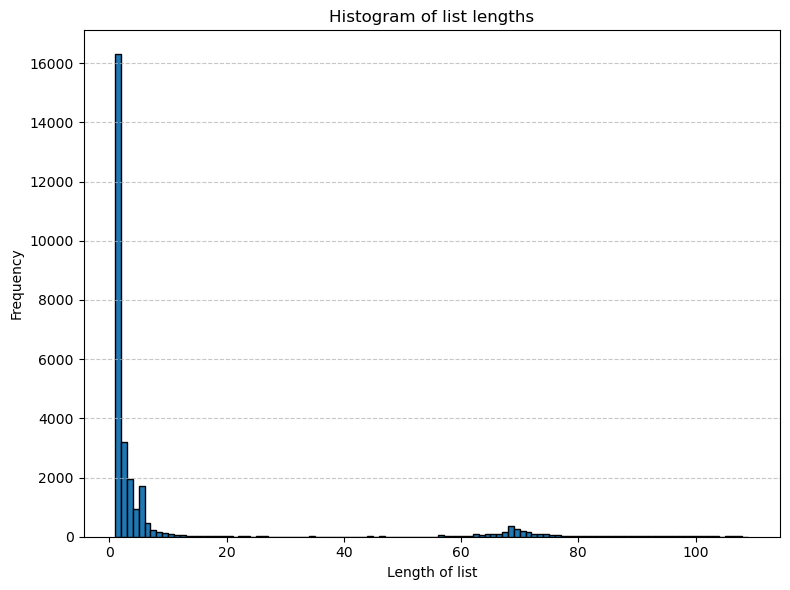

In [13]:
# Step 1: Compute the length of each list
rxn_model_origin['list_length'] = rxn_model_origin['bigg_models'].apply(len)

# Step 2: Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(rxn_model_origin['list_length'], bins=range(rxn_model_origin['list_length'].min(), rxn_model_origin['list_length'].max() + 2), edgecolor='black')
plt.xlabel('Length of list')
plt.ylabel('Frequency')
plt.title('Histogram of list lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
rxn_model_origin

,bigg_id,name,bigg_models
0,11DOCRTSTRNtm,11-deoxycorticosterone intracellular transport,"[Recon3D, iMM1415, iCHOv1, RECON1, iCHOv1_DG44]"
1,10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal","[Recon3D, iMM1415, iCHOv1, RECON1, iCHOv1_DG44]"
2,11DOCRTSTRNtr,11-deoxycorticosterone intracellular transport,"[Recon3D, iMM1415, iCHOv1, RECON1, iCHOv1_DG44]"
3,10FTHFtm,10-Formyltetrahydrofolate mitochondrial transp...,"[Recon3D, iMM1415, iCHOv1, RECON1, iCHOv1_DG44]"
4,10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal","[Recon3D, iMM1415, iCHOv1, iAT_PLT_636, RECON1..."
...,...,...,...
28297,ZYMSTESTH_SCe,Zymosterol ester hydrolase yeast specific ex...,[iMM904]
28298,ZYMSTR,Zymosterol reductase,[iRC1080]
28299,ZYMSTt,Zymosterol reversible transport,"[iMM904, iND750]"
28300,Zn2tex,Zinc (Zn+2) transport via diffusion (extracell...,"[iECO103_1326, iE2348C_1286, iEC1344_C, iEC134..."


In [20]:
# To give carveme soft constraints we need a tsv file with the reaction IDs and in the second columns a 0, i.e. we want to exclude these reactions
# https://carveme.readthedocs.io/en/latest/advanced.html#experimental-constraints
false_models = ["iYO844"]  # list of models that we found are "problematic"

# Step 1: Filter reactions where *all* associated models are in false_models
# i.e. For the given list "models" (which is one row of the rxn_model_origin df), return True only if every element m (every model from that row) is in the false_models list.
false_rxns = rxn_model_origin[
    rxn_model_origin["bigg_models"].apply(lambda models: all(m in false_models for m in models))
]

# Step 2: Extract BiGG reaction IDs
false_rxn_ids = false_rxns["bigg_id"].tolist()

# Step 3: Create DataFrame with ID and 0
output_df = pd.DataFrame({
    "ID": [f'R_{rxn_id}' for rxn_id in false_rxn_ids],  # Prefix "R_" because this is how reactions are named in the universal model that carveme uses
    "value": [0] * len(false_rxn_ids) # 0 because then CarveMe excludes those reactions
})


In [16]:
output_df

,ID,value
0,R_23CN2P1,0
1,R_2PGLYCt6,0
2,R_3AMBAt2,0
3,R_3AMPt6,0
4,R_3CMPt6,0
...,...,...
315,R_UNK5,0
316,R_UPP3MT_2,0
317,R_X00002,0
318,R_XYL14BASE,0


In [104]:
output_df.to_csv("../filtered_false_reactions.tsv", sep="\t", index=False, header=False)

# Manual, last checks

In [8]:
# Load SBML Models
models_path = "/home/lisa/Dokumente/Programmierung/Models/10_duplicate_removal/"
models_curation = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_curate")
    models_curation[name] = model

models_curation = {key: models_curation[key] for key in sorted(models_curation.keys())}  # sorts the dictionary alphabetically
AA1_curate, AA2_curate, AA3_curate, AA4_curate, AA5_curate, AA6_curate, AA7_curate = [models_curation[f"AA{i}_curate"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


in AA4:
6PGALSZ_1: h2o_c + lac6p_c <=> dgal6p_c + glc_D_B_c
{'h2o_c': 0, 'lac6p_c': -2, 'dgal6p_c': -2, 'glc_D_B_c': 0}

In [11]:
overwrite_reaction(AA4_curate, "6PGALSZ_1", {
    "h2o_c": -1.0,
    "lac6p_c": -1.0,
    "dgal6p_c": 1.0,
    "glc__D_c": 1.0
})
delete_metabolite(AA4_curate, "glc_D_B_c")
if "6PGALSZ_1" in AA4_curate.reactions and "6PGALSZ" not in AA4_curate.reactions:
    AA4_curate.reactions.get_by_id("6PGALSZ_1").id = "6PGALSZ"

In [12]:
path = f"../Models/10_duplicate_removal/AA4_deleted_duplicates.xml"
write_sbml_model(AA4_curate, path)